# Exploring Embeddings with a naive RAG implementation

Retrieval-Augmented Generation (RAG) is a natural language processing (NLP) model architecture that combines the powers of two major components: a retriever and a generator. This approach aims to enhance the generation of human-like text by incorporating relevant information retrieved from a large dataset or corpus. The RAG model architecture is particularly useful in tasks like question answering, fact verification, and content creation where the integration of external knowledge can significantly improve the quality and relevance of the generated text.

In [1]:
#!pip install -q pdfplumber;
#!pip install -q sentence_transformers;

The text extraction next uses regular expressions (regex) to detect the start of a section or subsection. To help develop and especially test regex that I generally get ChatGPT to write, I find this website very helpful:
https://regex101.com


## PDF processing

In this implementation, the PDF processing is done one page at a time. This works for very large documents, but has the drawback that sections or subsections going across pages will fall in different chunks.  Here all subsections are processed a single chunk. For large subsections, it would probably be better to separate them into separate chunks. However, in this case, overlapping these chunks is recommended.

As the pages are processed, metadata is assembled and captured with each chunk of text.  This is important to keep track of chunks once they are vectorized (see below). 

Embeddings are then created, using a local and dedicated LLM (all-MiniLM-L6-v2).

In [2]:
from pprint import pprint

In [3]:
import re

def is_section_start(line):
    return re.match(r'^\d+\s', line)

def is_subsection_start(line):
    return re.match(r'^\d+\.\d+\s', line)

def extract_sections(text):
    
    chunks_with_metadata = []
    current_section_title = ''
    current_subsection_title = ''
    current_chunk_content = []    # Accumulate lines of text here
    chunk_type = 'section_text'   # Default to section text

    def append_chunk():
        chunks_with_metadata.append({
            'section_title': current_section_title,
            'subsection_title': current_subsection_title,
            'chunk_type': chunk_type,
            'content': "\n".join(current_chunk_content)  # Join accumulated lines
        })
        return

    def add_chunk():
        nonlocal current_chunk_content
        if current_chunk_content:
            chunks_with_metadata = append_chunk()
            current_chunk_content = []  # Reset for the new chunk
        return
    
    for line in text.strip().split('\n'):
        line = line.strip()
        if not line:
            continue  # Skip empty lines
    
        # Check for section or subsection markers
        if is_section_start(line):
            # Save the previous chunk before resetting for the new section
            add_chunk()
            current_section_title = line
            current_subsection_title = ''
            chunk_type = 'section_text'
    
        elif is_subsection_start(line):
            # Save the previous chunk before resetting for the new subsection
            add_chunk()
            current_subsection_title = line
            chunk_type = 'subsection_text'
    
        else:
            current_chunk_content.append(line)
    
    # Don't forget to save the last chunk after exiting the loop
    if current_chunk_content:
        append_chunk()
        
    return chunks_with_metadata


In [4]:
import pdfplumber
from sentence_transformers import SentenceTransformer

# Load a pre-trained model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2') # 65MB in RAM?

# Function to extract text and split by headers (2 levels)
def extract_and_split(pdf_path):
    chunks_with_metadata = []
    with pdfplumber.open(pdf_path) as pdf:
        for page_number, page in enumerate(pdf.pages, start=1):
            text = page.extract_text()
            for section in extract_sections(text):
                metadata = {
                    "pdf_name": pdf_path.split('/')[-1],  # Get the file name
                    "section_title": section['section_title'],
                    "page_number": page_number,
                    "chunk_type": section['chunk_type'],
                    "content": section['content'],
                }
                if section['subsection_title'].strip() :
                    metadata["subsection_title"] = section['subsection_title']
                chunks_with_metadata.append((section['content'], metadata))
    return chunks_with_metadata

# Function to create embeddings with metadata
def create_embeddings_with_metadata(chunks_with_metadata):
    embeddings_with_metadata = []
    for text_chunk, metadata in chunks_with_metadata:
        embedding = model.encode([text_chunk])[0]  # Encode the chunk and take the first element
        embedding_with_metadata = {
            "embedding": embedding,
            "metadata": metadata
        }
        embeddings_with_metadata.append(embedding_with_metadata)
    return embeddings_with_metadata

_chunks_with_metadata = extract_and_split('doc.pdf')
_embeddings_with_metadata = create_embeddings_with_metadata(_chunks_with_metadata)

def get_embeddings():
    return [e['embedding'] for e in _embeddings_with_metadata]

def get_text_content():
    return [e['metadata']['content'] for e in _embeddings_with_metadata]


In [5]:
# Summary
print(f'{"="*80}\n\nSummary:')
print(f'Created {len(_embeddings_with_metadata)} embeddings')
print(f'Each embedding is a vector of {len(_embeddings_with_metadata[10]['embedding'])} elements')
print(f'\n{"="*80}\n')
print(f'Let\'s have a look at the embeddings...')

# Display the chunks with metadata
for i, chunk in enumerate(_chunks_with_metadata):
    content, metadata = chunk
    print(f'\n{i}>{"-"*78}')
    if metadata['chunk_type'] == 'section_text':
        print(f"{metadata['section_title']} (type: {metadata['chunk_type']})")
    else: # subsection
        print(f"{metadata.get('subsection_title','')} (type: {metadata['chunk_type']})")
    print(f"Content:\n{content}") # content is also in the matadata, key=content

print(f'\n')



Summary:
Created 20 embeddings
Each embedding is a vector of 384 elements


Let's have a look at the embeddings...

0>------------------------------------------------------------------------------
1 Flukarian (type: section_text)
Content:
The flukarian (Flukaris familiaris or Flukaris wingus familiaris) is a wild flying mammal,
descendent of an unknow alien species. It flies for most of its life and only lands to mate and
perform nuptial rituals. The flukarian was discovered on Alpha Centurion system by the joint
ESA-NASA mission in 2434. They feed on bad ideas and skinny astronauts.

1>------------------------------------------------------------------------------
1.1 What flukarians play with (type: subsection_text)
Content:
Flukarians like to fly high above the clouds and perform impressive aerobatics tricks.
Here is a list of favourite toys:
a. astronaut
b. rocket booster
c. clouds

2>------------------------------------------------------------------------------
1.2 How long do flu

## Embeddings and vectors

Now that embeddings are created out of our document, and that they can be queried for proximity with the question, we can craft a prompt including the embeddings (as text).

The function `cosine_similarity` (below) computes the cosine similarity between two vectors, `vec_a` and `vec_b`. 

Cosine similarity is a measure used in vector space that helps determine how similar the two vectors are, irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is particularly used in high-dimensional positive spaces like text analysis and other kinds of vector-based semantics.

Here’s what the function does, step-by-step:

1. `dot(vec_a, vec_b)`: This calculates the dot product of the two vectors. The dot product is a scalar representation of the vectors' multiplication, reflecting the sum of the products of their corresponding entries.

2. `norm(vec_a)` and `norm(vec_b)`: These calculate the Euclidean norm (or magnitude) of the vectors. The norm of a vector is the square root of the sum of the squares of its components.

3. The entire expression `dot(vec_a, vec_b) / (norm(vec_a) * norm(vec_b))` computes the cosine similarity. It divides the dot product of the two vectors by the product of their norms (magnitudes). The result is a value between -1 and 1:

   - A cosine similarity of 1 means the vectors are identical in orientation (i.e., they are pointing in the same direction).
   - A cosine similarity of -1 means the vectors are diametrically opposed (i.e., they are pointing in completely opposite directions).
   - A cosine similarity of 0 means the vectors are orthogonal (i.e., independent or perpendicular to each other in the vector space).
   - Values between 0 and 1 indicate varying degrees of similarity, with values closer to 1 signifying greater similarity.

This function is commonly used in text analysis, information retrieval, and machine learning to measure how similar two documents or sets of data are based on their vector representations.

In [6]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(vec_a, vec_b):
    '''Compute the cosine similarity between two vectors.'''
    return dot(vec_a, vec_b) / (norm(vec_a) * norm(vec_b))


Now let's ask a question. To do that, we extract embeddings with similarities to the question (query) embedding.  We then rank them to provide the top ones.

In [22]:
def best_embeddings(query_embedding, document_embeddings):
    # Compute similarities
    similarities = [cosine_similarity(query_embedding, doc_emb) for doc_emb in document_embeddings]
    
    # Rank documents based on similarity
    ranked_docs = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    
    # Get top N documents
    top_n = 10
    top_docs_indices = ranked_docs[:top_n]
    return top_docs_indices


In [8]:
def print_best_embeddings(question, top_docs_indices):
    print(f"To the question: \"{question}\", the most interesting chunks are:\n\n")
    texts = get_text_content()
    for i in top_docs_indices:
        print(f"{i}>{'-'*78}\n{texts[i]}\n")
    

In [9]:
question = 'What toys do cats play with?'
question = 'Which animal is colour blind?'
question = 'Which animal is challenged to see all tones?'
# question = 'Who enjoys round things?'
# question = 'Who enjoys playing with small mammals?'

def show_best_embeddings(question):
    embeddings = get_embeddings()
    question_embedding = model.encode([question])[0]  # Encode the chunk and take the first element (the vector)
    print_best_embeddings(question, best_embeddings(question_embedding, embeddings))
    return

show_best_embeddings(question)

To the question: "Which animal is challenged to see all tones?", the most interesting chunks are:


7>------------------------------------------------------------------------------
Dogs like to play with balls and stick. As they are colour blind, the colour of their toys don't
really matter. It generally depends on the preference of their owners.
Here is a list of favourite toys:
g. balls
h. stick
i. frisbee

6>------------------------------------------------------------------------------
The dog (Canis familiaris or Canis lupus familiaris) is a domesticated descendant of the wolf.
Also called the domestic dog, it is derived from extinct gray wolves, and the gray wolf is the
dog's closest living relative. The dog was the first species to be domesticated by humans.
Hunter-gatherers did this over 15,000 years ago in Oberkassel, Bonn, which was before the
development of agriculture. Due to their long association with humans, dogs have expanded
to a large number of domestic individuals and

## Visualisation of embeddings

We can cluster embeddings, such that we can visualise their proximity or similarity, and/or detect anomalies.

In [10]:
!pip install -qq umap-learn seaborn plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
import umap.umap_ as umap
import plotly.express as px
import pandas as pd


def plot_umap_with_labels(data, texts, n_neighbors=10, min_dist=0.1):

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, n_jobs=1)

    # Fit and transform the data
    embedding = reducer.fit_transform(data)

    df = pd.DataFrame({
        'embedding_x': embedding[:, 0],
        'embedding_y': embedding[:, 1],
        'text': map(lambda x: x[:50], texts) # Truncate strings to the first 10 characters
    })

    fig = px.scatter(df, x='embedding_x', y='embedding_y',
                     hover_data={'embedding_x': False, 'embedding_y': False, 'text': True},
                    )
    fig.update_layout(
        title={
            'text': "Embeddings grouping",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
    )
    
    fig.show()
    return


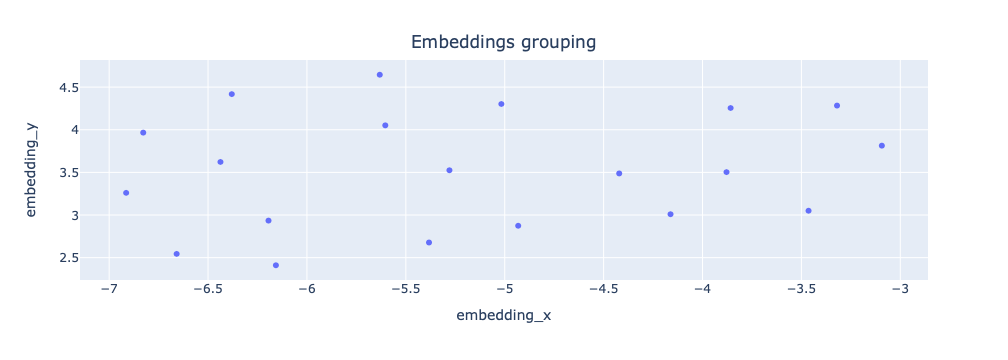

In [18]:
def plot_embeddings():
    embeddings = get_embeddings()
    texts = get_text_content()
    plot_umap_with_labels(embeddings, texts)
    return

plot_embeddings()

## Chatting with our data

Now that embeddings are created out of our document, and that they can be queried for proximity with the question, we can craft a prompt including the embeddings (as text).

In [13]:
import requests
import json

def get_response(prompt):

    # Define the URL of the local LLM server
    url = "http://localhost:11434/api/generate"

    # Define the data to be sent in the request
    data = {
        "model": "llama2",
        "prompt": prompt,
        "stream": False
    }
    
    # Convert the data to JSON format
    data_json = json.dumps(data)
    
    # Send the POST request to the local LLM server
    response = requests.post(url, data=data_json)

    answer = ''
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response
        response_data = response.json()
        # Print the generated text
        answer = response_data.get("response", "No text generated")
    else:
        answer = f"Failed to get response from the server, status code: {response.status_code}"

    return answer

In [14]:
def get_prompt(question):
    question_embedding = model.encode([question])[0]
    embeddings = get_embeddings()
    relevent_embeddings_idx = best_embeddings(question_embedding, embeddings)
    texts = get_text_content()
    relevent_embeddings = [texts[i] for i in relevent_embeddings_idx]

    text_embeddings = f'\n{80*"-"}\n'.join(relevent_embeddings)
    
    prompt = f'''
You are a helpful and very methodical assistant.
Pay particular attention to the list of text items that follow:
{80*"-"}
{text_embeddings}
{80*"-"}
Using exclusively the above text items, answer the following question in the most precise and specific way possible:
{question}
'''
    return prompt

In [23]:
prompt = get_prompt('rank the animals based on their life expectancy')
print(prompt)


You are a helpful and very methodical assistant.
Pay particular attention to the list of text items that follow:
--------------------------------------------------------------------------------
Birds in general have a relatively short life, except for large birds, who can live for several
decades.
--------------------------------------------------------------------------------
Cats have nine lives. They therefore live a very long time.
--------------------------------------------------------------------------------
Flukarians can potentially live forever, since they can regenerate all their cells. They
therefore in theory can live forever, unless an accident happens to them.
--------------------------------------------------------------------------------
Birds are a group of warm-blooded vertebrates constituting the class Aves (/ˈeɪviːz/),
characterised by feathers, toothless beaked jaws, the laying of hard-shelled eggs, a high
metabolic rate, a four-chambered heart, and a strong yet 

Now that we have a prompt, we can ask an LLM (Llama2 in this case), to provide the response, based on our data.

In [24]:
# This can take a while...

response = get_response(prompt)
print(response)

Based on the information provided in the text, here is a ranking of the animals listed by their estimated life expectancy:

1. Birds - with some species living for several decades, the average life expectancy of birds is likely to be around 20-30 years.
2. Cats - with their famous nine lives, cats have an estimated lifespan of around 15-20 years.
3. Dogs - as domesticated descendants of wolves, dogs have an average life expectancy of around 10-15 years.
4. Flukarians - being a wild flying mammal, the lifespan of flukarians is estimated to be around 5-10 years.
5. Wolves - as wild animals, wolves have an average life expectancy of around 5-7 years in the wild.

It's important to note that these estimates are based on the information provided in the text and may not reflect real-world data or scientific research.
